In [1]:
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np

from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout


Using TensorFlow backend.


In [2]:
df = pd.read_csv('dataset_for_lstm.csv', index_col=0)

In [3]:
print(df.shape)
df.head()

(16678, 9)


,price,ask,bid,high,last,low,open,volume,volumeQuote
timestamp,,,,,,,,,
2018-01-31 00:46:46,0.106562,0.106676,0.106503,0.108403,0.106538,0.103069,0.104695,54213.61,5744.844128
2018-01-31 00:46:56,0.106589,0.106676,0.106503,0.108403,0.106538,0.103069,0.104695,54213.61,5744.844128
2018-01-31 00:47:06,0.106605,0.106676,0.106503,0.108403,0.106538,0.103069,0.104695,54213.61,5744.844128
2018-01-31 00:47:16,0.106609,0.106676,0.106503,0.108403,0.106538,0.103069,0.104695,54213.61,5744.844128
2018-01-31 00:47:26,0.106660,0.106676,0.106503,0.108403,0.106538,0.103069,0.104695,54213.61,5744.844128


close_off_high represents the gap between the closing price and price high for that day, where values of -1 and 1 mean the closing price was equal to the daily low or daily high, respectively.

The volatility column is simply the difference between high and low price divided by the opening price.

In [4]:
df['close_off_high'] = 2 * (df['high'] - df['price']) / (df['high'] - df['low']) - 1
df['volatility'] = (df['high'] - df['low']) / (df['open'])

In [5]:
df.drop(['ask', 'bid', 'high', 'last', 'low', 'open', 'volumeQuote'], axis=1, inplace=True)

In [6]:
df.head()

,price,volume,close_off_high,volatility
timestamp,,,,
2018-01-31 00:46:46,0.106562,54213.61,-0.309711,0.050948
2018-01-31 00:46:56,0.106589,54213.61,-0.319835,0.050948
2018-01-31 00:47:06,0.106605,54213.61,-0.325834,0.050948
2018-01-31 00:47:16,0.106609,54213.61,-0.327334,0.050948
2018-01-31 00:47:26,0.106660,54213.61,-0.346457,0.050948


In [50]:
split_line = int(df.shape[0] * 0.7)
training_set, test_set = df[:split_line], df[split_line:]

In [51]:
training_set.shape

(11674, 4)

In [52]:
window_len = 10
norm_cols = ['volume']

In [53]:
LSTM_training_inputs = []
for i in range(len(training_set) - window_len):
    temp_set = training_set[i:(i + window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col] / temp_set[col].iloc[0] - 1
    LSTM_training_inputs.append(temp_set)
LSTM_training_outputs = (training_set['price'][window_len:].values/training_set['price'][:-window_len].values)-1

In [54]:
LSTM_test_inputs = []
for i in range(len(test_set) - window_len):
    temp_set = test_set[i:(i + window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_test_inputs.append(temp_set)
LSTM_test_outputs = (test_set['price'][window_len:].values / test_set['price'][:-window_len].values) - 1

In [55]:
LSTM_training_inputs[0]

,price,volume,close_off_high,volatility
timestamp,,,,
2018-01-31 00:46:46,0.106562,0.000000,-0.309711,0.050948
2018-01-31 00:46:56,0.106589,0.000000,-0.319835,0.050948
2018-01-31 00:47:06,0.106605,0.000000,-0.325834,0.050948
2018-01-31 00:47:16,0.106609,0.000000,-0.327334,0.050948
2018-01-31 00:47:26,0.106660,0.000000,-0.346457,0.050948
2018-01-31 00:47:36,0.106662,0.002209,-0.347207,0.050974
2018-01-31 00:47:46,0.106750,0.002209,-0.380202,0.050974
2018-01-31 00:47:56,0.106703,0.002209,-0.362580,0.050974
2018-01-31 00:48:06,0.106854,0.002546,-0.419198,0.050974


In [56]:
LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
LSTM_training_inputs = np.array(LSTM_training_inputs)

LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
LSTM_test_inputs = np.array(LSTM_test_inputs)

In [57]:
def build_model(inputs, output_size, neurons, activ_func="linear",
                dropout=0.25, loss="mean_squared_error", optimizer="adam"):
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [63]:
np.random.seed(202)

model = build_model(LSTM_training_inputs, output_size=1, neurons=20)
LSTM_training_outputs = (training_set['price'][window_len:].values / training_set['price'][:-window_len].values) - 1

In [64]:
model_history = model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                            epochs=20, batch_size=32, shuffle=True, validation_split=0.3)

Train on 8164 samples, validate on 3500 samples
Epoch 1/20
8164/8164 [==============================] - 3s 418us/step - loss: 8.6465e-04 - val_loss: 1.5284e-05
Epoch 2/20
8164/8164 [==============================] - 3s 370us/step - loss: 7.2174e-05 - val_loss: 1.4800e-05
Epoch 3/20
8164/8164 [==============================] - 3s 370us/step - loss: 1.5968e-05 - val_loss: 4.2266e-06
Epoch 4/20
8164/8164 [==============================] - 3s 370us/step - loss: 4.0306e-06 - val_loss: 1.0395e-06
Epoch 5/20
8164/8164 [==============================] - 3s 377us/step - loss: 2.1289e-06 - val_loss: 8.8509e-07
Epoch 6/20
8164/8164 [==============================] - 3s 373us/step - loss: 1.5461e-06 - val_loss: 9.8080e-07
Epoch 7/20
8164/8164 [==============================] - 3s 371us/step - loss: 1.3545e-06 - val_loss: 2.7661e-06
Epoch 8/20
8164/8164 [==============================] - 3s 372us/step - loss: 1.2088e-06 - val_loss: 6.5691e-07
Epoch 9/20
8164/8164 [==============================] - 

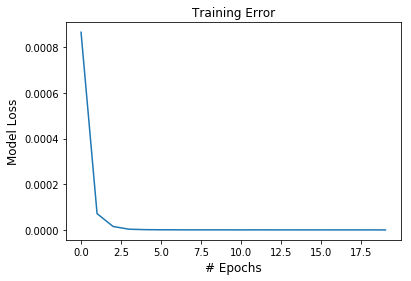

In [65]:
fig, ax1 = plt.subplots(1,1)

ax1.plot(model_history.epoch, model_history.history['loss'])
ax1.set_title('Training Error')

if model.loss == 'mae':
    ax1.set_ylabel('Mean Absolute Error (MAE)',fontsize=12)
# just in case you decided to change the model loss calculation
else:
    ax1.set_ylabel('Model Loss',fontsize=12)
ax1.set_xlabel('# Epochs',fontsize=12)
plt.show()

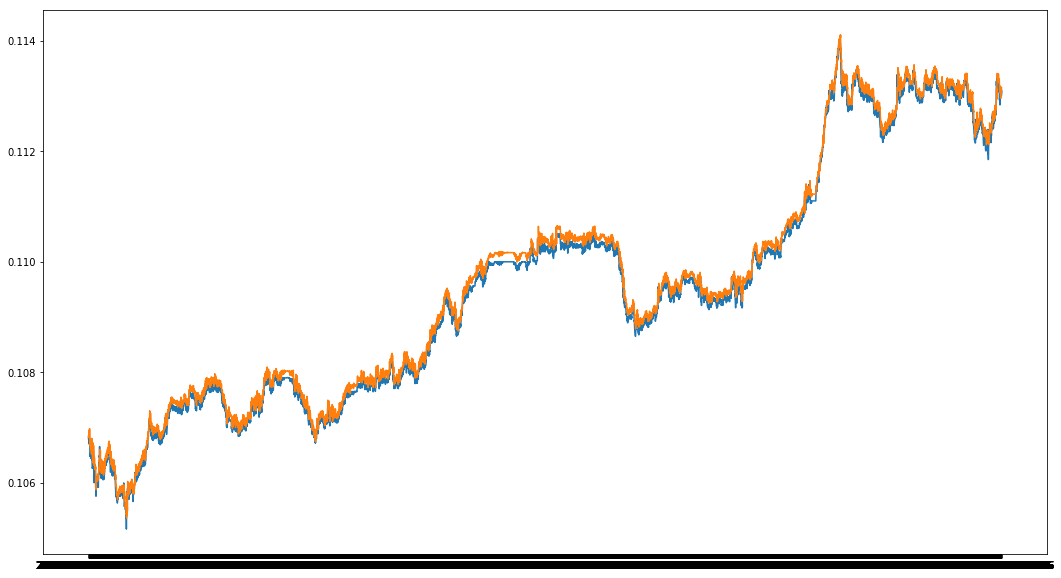

In [66]:
fig, ax1 = plt.subplots(1,1)
ax1.plot(df[:split_line].index[window_len:].astype(datetime.datetime),
         training_set['price'][window_len:], label='Actual')
ax1.plot(df[:split_line].index[window_len:].astype(datetime.datetime),
         ((np.transpose(model.predict(LSTM_training_inputs))+1) * training_set['price'].values[:-window_len])[0], 
         label='Predicted')
fig.set_size_inches(18, 10)
plt.show()

ny ne ymeu ua krasivo risovat'

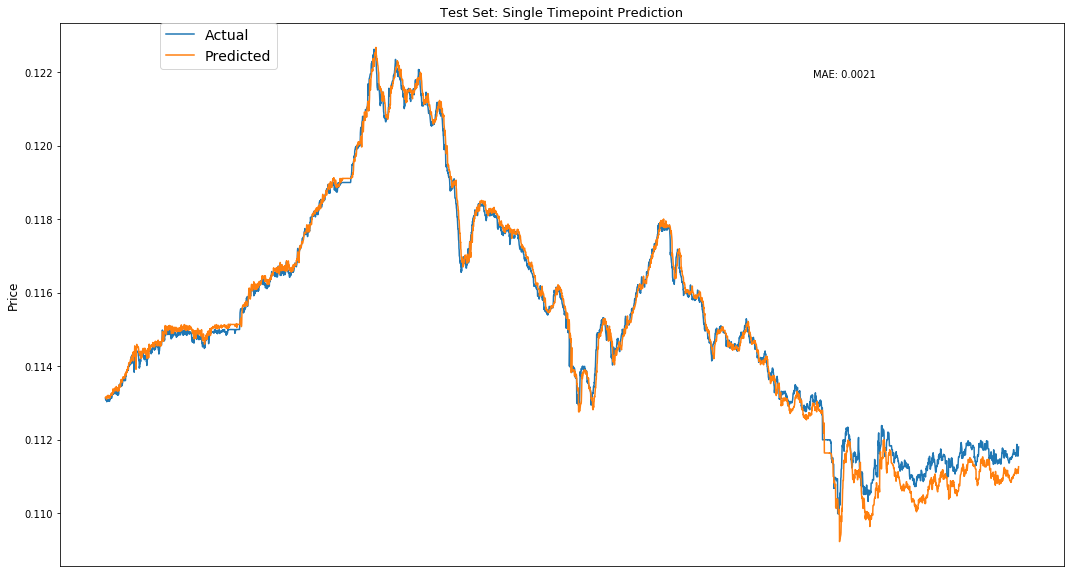

In [67]:
fig, ax1 = plt.subplots(1,1)
ax1.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
ax1.set_xticklabels([datetime.date(2017,i+1,1).strftime('%b %d %Y')  for i in range(12)])
ax1.plot(df[split_line:].index[window_len:].astype(datetime.datetime),
         test_set['price'][window_len:], label='Actual')
ax1.plot(df[split_line:].index[window_len:].astype(datetime.datetime),
         ((np.transpose(model.predict(LSTM_test_inputs))+1) * test_set['price'].values[:-window_len])[0], 
         label='Predicted')
ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(model.predict(LSTM_test_inputs))+1)-\
            (test_set['price'].values[window_len:])/(test_set['price'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
ax1.set_title('Test Set: Single Timepoint Prediction',fontsize=13)
ax1.set_ylabel('Price',fontsize=12)
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})
fig.set_size_inches(18, 10)
plt.show()

LSTM model to predict crypto prices for the next 5 days

In [41]:
np.random.seed(202)

pred_range = 5

model_5_days = build_model(LSTM_training_inputs, output_size=pred_range, neurons = 20)

# model output is next 5 prices normalised to 10th previous closing price
LSTM_training_outputs = []
for i in range(window_len, len(training_set['price']) - pred_range):
    LSTM_training_outputs.append((training_set['price'][i:i + pred_range].values /
                                  training_set['price'].values[i - window_len])-1)
LSTM_training_outputs = np.array(LSTM_training_outputs)

In [42]:
model_5_days_history = model_5_days.fit(LSTM_training_inputs[:-pred_range], LSTM_training_outputs, 
                            epochs=50, batch_size=32, shuffle=True, validation_split=0.3)

Train on 10496 samples, validate on 4499 samples
Epoch 1/50
10496/10496 [==============================] - 4s 391us/step - loss: 0.0021 - val_loss: 8.3640e-05
Epoch 2/50
10496/10496 [==============================] - 4s 368us/step - loss: 1.3450e-04 - val_loss: 2.6696e-05
Epoch 3/50
10496/10496 [==============================] - 4s 368us/step - loss: 6.0245e-05 - val_loss: 1.9266e-05
Epoch 4/50
10496/10496 [==============================] - 4s 370us/step - loss: 3.6245e-05 - val_loss: 1.5848e-05
Epoch 5/50
10496/10496 [==============================] - 4s 370us/step - loss: 2.4535e-05 - val_loss: 1.3271e-05
Epoch 6/50
10496/10496 [==============================] - 4s 370us/step - loss: 1.7127e-05 - val_loss: 1.2048e-05
Epoch 7/50
10496/10496 [==============================] - 4s 370us/step - loss: 1.2495e-05 - val_loss: 1.0732e-05
Epoch 8/50
10496/10496 [==============================] - 4s 369us/step - loss: 8.9139e-06 - val_loss: 8.8750e-06
Epoch 9/50
10496/10496 [===================

In [43]:
pred_prices = ((model_5_days.predict(LSTM_test_inputs)[:-pred_range][::pred_range]+1)*\
                   test_set['price'].values[:-(window_len + pred_range)][::5].reshape(int(np.ceil((len(LSTM_test_inputs)-pred_range)/float(pred_range))),1))

In [44]:
pred_prices.shape

(331, 5)

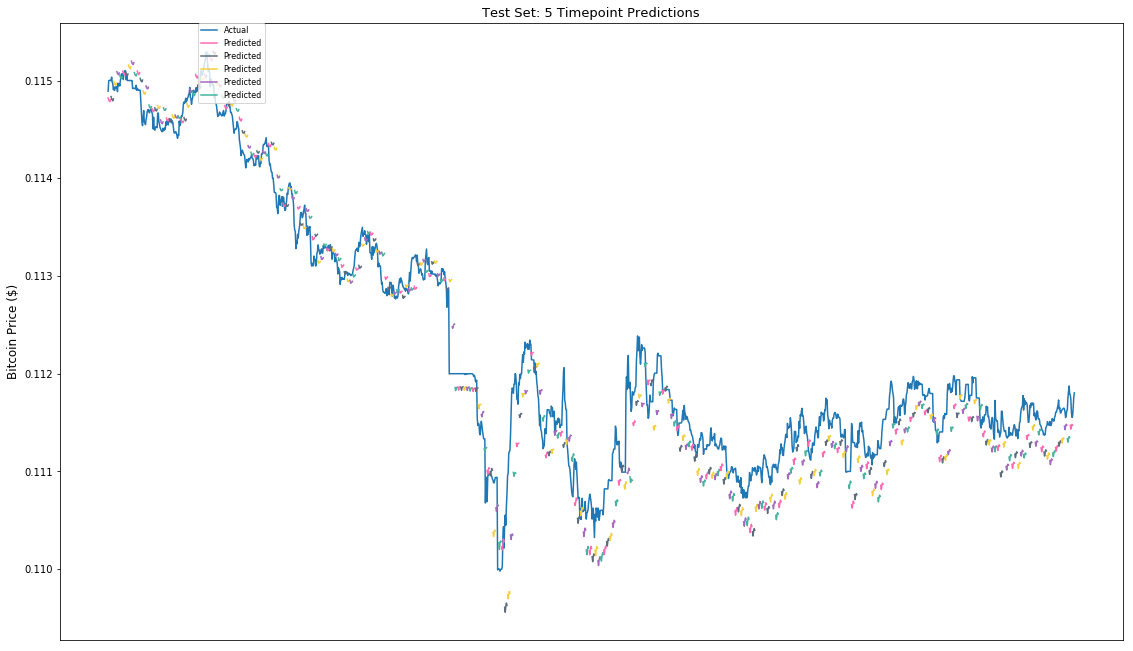

In [47]:
pred_colors = ["#FF69B4", "#5D6D7E", "#F4D03F","#A569BD","#45B39D"]
fig, ax1 = plt.subplots(1,1)
ax1.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
ax1.plot(df[split_line:].index[window_len:].astype(datetime.datetime),
         test_set['price'][window_len:], label='Actual')
for i, pred in enumerate(pred_prices):
    # Only adding lines to the legend once
    if i<5:
        ax1.plot(df[split_line:].index[window_len:].astype(datetime.datetime)[i*pred_range:i*pred_range+pred_range],
                 pred, color=pred_colors[i%5], label="Predicted")
    else: 
        ax1.plot(df[split_line:].index[window_len:].astype(datetime.datetime)[i*pred_range:i*pred_range+pred_range],
                 pred, color=pred_colors[i%5])
ax1.set_title('Test Set: 5 Timepoint Predictions',fontsize=13)
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax1.set_xticklabels('')
ax1.legend(bbox_to_anchor=(0.13, 1), loc=2, borderaxespad=0., prop={'size': 8})
fig.tight_layout()
fig.set_size_inches(18, 10)
plt.show()